# **IMPORT STATEMENTS**

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# **LOADING AND UNDERSTANDING THE DATA**

In [ ]:
data = pd.read_excel('bank.xlsx')
data

age           job   marital  ... previous     poutcome    y
0       49   blue-collar   married  ...        0  nonexistent   no
1       37  entrepreneur   married  ...        1      failure   no
2       78       retired   married  ...        0  nonexistent  yes
3       36        admin.   married  ...        0  nonexistent   no
4       59       retired  divorced  ...        0  nonexistent   no
...    ...           ...       ...  ...      ...          ...  ...
32945   28      services    single  ...        0  nonexistent   no
32946   52    technician   married  ...        1      failure   no
32947   54        admin.   married  ...        0  nonexistent   no
32948   29        admin.   married  ...        0  nonexistent   no
32949   35        admin.   married  ...        0  nonexistent   no

[32950 rows x 16 columns]

In [ ]:
data.shape

(32950, 16)

In [ ]:
data.describe()

age      duration      campaign         pdays      previous
count  32950.000000  32950.000000  32950.000000  32950.000000  32950.000000
mean      40.014112    258.127466      2.560607    962.052413      0.174719
std       10.403636    258.975917      2.752326    187.951096      0.499025
min       17.000000      0.000000      1.000000      0.000000      0.000000
25%       32.000000    103.000000      1.000000    999.000000      0.000000
50%       38.000000    180.000000      2.000000    999.000000      0.000000
75%       47.000000    319.000000      3.000000    999.000000      0.000000
max       98.000000   4918.000000     56.000000    999.000000      7.000000

In [ ]:
data.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

*No null values are present in the dataset*

# **CLEANING DATA**

## **Converting Duration to Hours**

*Here, we are converting the duration column values into hours for ease of understanding*

In [ ]:
data['duration'] = data['duration'].apply(lambda n:n/60).round(2)
data

age           job   marital  ... previous     poutcome    y
0       49   blue-collar   married  ...        0  nonexistent   no
1       37  entrepreneur   married  ...        1      failure   no
2       78       retired   married  ...        0  nonexistent  yes
3       36        admin.   married  ...        0  nonexistent   no
4       59       retired  divorced  ...        0  nonexistent   no
...    ...           ...       ...  ...      ...          ...  ...
32945   28      services    single  ...        0  nonexistent   no
32946   52    technician   married  ...        1      failure   no
32947   54        admin.   married  ...        0  nonexistent   no
32948   29        admin.   married  ...        0  nonexistent   no
32949   35        admin.   married  ...        0  nonexistent   no

[32950 rows x 16 columns]

## **Removing Outliers**

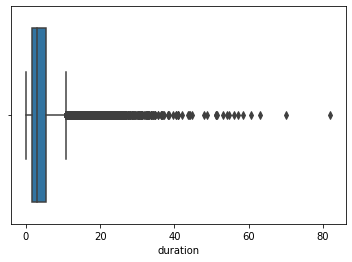

In [ ]:
sns.boxplot(data=data,x='duration')

*Implementing the IQR Method to remove the outliers*

In [ ]:
q3 = data['duration'].quantile(.75)
q1 = data['duration'].quantile(.25)
iqr = q3-q1
iqr

3.6000000000000005

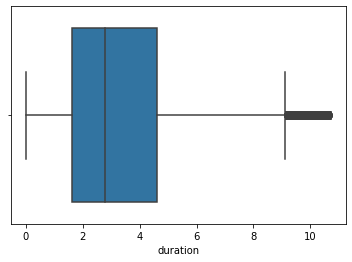

In [ ]:
upperrange = q3+1.5*iqr
bottomrange = q1-1.5*iqr
df = data[(data['duration']>bottomrange) & (data['duration']<upperrange)] 
sns.boxplot(data=df,x='duration')

In [ ]:
data.shape

(32950, 16)

In [ ]:
category_cols = list(data.select_dtypes(include=['object']))
category_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

# **EXPLORATORY DATA ANALYSIS**


### **Histogram**

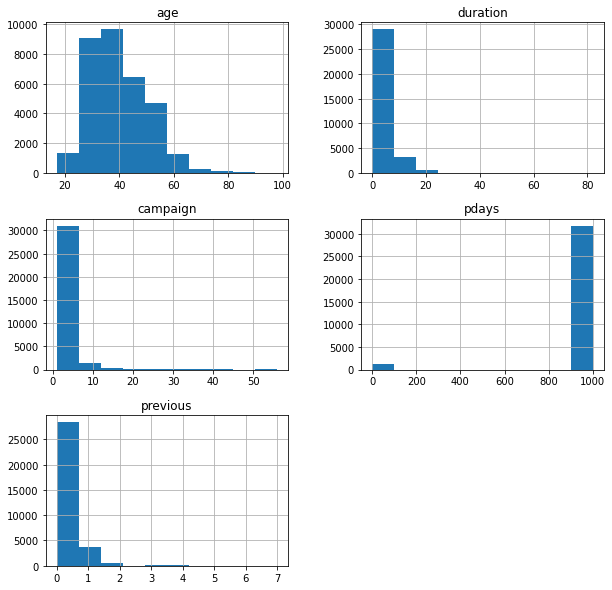

In [ ]:
data.hist(figsize=(10,10))
plt.show()

### **Scatter Plot**

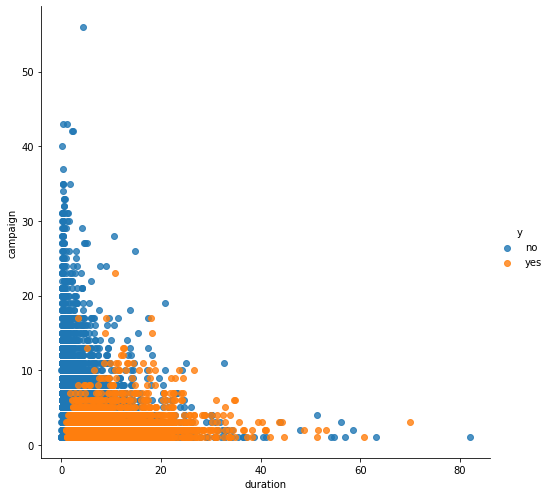

In [ ]:
sns.lmplot(x='duration', y='campaign',data = data,hue = 'y',fit_reg = False,scatter_kws={'alpha':0.8,}, height =7)

*Here, we can observe that a majority of customers tend to accept the term deposit, when duration is in the range of 0 to 20*

### **KDE Plot**

Text(0, 0.5, 'Y')

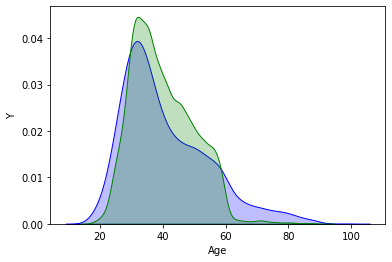

In [ ]:
fig, ax = plt.subplots()

sns.kdeplot(data[data["y"]=='yes']["age"], shade=True, color="blue", label="Choose", ax=ax)
sns.kdeplot(data[data["y"]=='no']["age"], shade=True, color="green", label="Did not choose", ax=ax)

ax.set_xlabel("Age")
ax.set_ylabel("Y")

### **Histogram**

(array([1.346e+03, 9.061e+03, 9.629e+03, 6.454e+03, 4.682e+03, 1.288e+03,
        2.650e+02, 1.540e+02, 6.900e+01, 2.000e+00]),
 array([17. , 25.1, 33.2, 41.3, 49.4, 57.5, 65.6, 73.7, 81.8, 89.9, 98. ]),
 <a list of 10 Patch objects>)

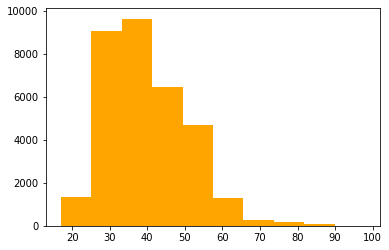

In [ ]:
plt.hist(data['age'], color="orange")

*A majority of customers called is in the age of 30s and 40s (33 to 48 years 
old fall within the 25th to 75th percentiles). The distribution of customer age is fairly normal with a small standard deviation.*

### **Pie Chart**

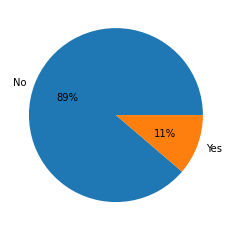

In [ ]:
labels = ['No', 'Yes']
y_data = data.groupby('y')['y'].count()
plt.pie(y_data,labels=labels, autopct='%.0f%%')
plt.show()

*A high majority of people usually don't choose to opt for term deposit*

# **LOGISTIC REGRESSION**

## **Data Pre-Processing**

In [ ]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

*Converting selected columns into dummies using the pandas 'get_dummies' function. The function encodes a 1 if the value is present and if not it assigns a 0.*

In [ ]:
new_data = pd.get_dummies(data[['job', 'marital','education','default','housing','loan','contact','month','day_of_week','poutcome']], drop_first=True)
new_data

job_blue-collar  ...  poutcome_success
0                    1  ...                 0
1                    0  ...                 0
2                    0  ...                 0
3                    0  ...                 0
4                    0  ...                 0
...                ...  ...               ...
32945                0  ...                 0
32946                0  ...                 0
32947                0  ...                 0
32948                0  ...                 0
32949                0  ...                 0

[32950 rows x 43 columns]

In [ ]:
y_data = data['y']
age_data = data['age']
duration_data = data['duration']
campaign_data = data['campaign']
clean_data = pd.concat([y_data,age_data,duration_data,campaign_data, new_data], axis=1)

In [ ]:
clean_data

y  age  ...  poutcome_nonexistent  poutcome_success
0       no   49  ...                     1                 0
1       no   37  ...                     0                 0
2      yes   78  ...                     1                 0
3       no   36  ...                     1                 0
4       no   59  ...                     1                 0
...    ...  ...  ...                   ...               ...
32945   no   28  ...                     1                 0
32946   no   52  ...                     0                 0
32947   no   54  ...                     1                 0
32948   no   29  ...                     1                 0
32949   no   35  ...                     1                 0

[32950 rows x 47 columns]

In [ ]:
clean_data['y']  = clean_data['y'].replace('yes',1)
clean_data['y']  = clean_data['y'].replace('no',0)

In [ ]:
clean_data

y  age  ...  poutcome_nonexistent  poutcome_success
0      0   49  ...                     1                 0
1      0   37  ...                     0                 0
2      1   78  ...                     1                 0
3      0   36  ...                     1                 0
4      0   59  ...                     1                 0
...   ..  ...  ...                   ...               ...
32945  0   28  ...                     1                 0
32946  0   52  ...                     0                 0
32947  0   54  ...                     1                 0
32948  0   29  ...                     1                 0
32949  0   35  ...                     1                 0

[32950 rows x 47 columns]

In [ ]:
df1 = clean_data[['marital_single', 'marital_married', 'marital_unknown', 'y']].copy()
df2 = clean_data[['job_blue-collar', 'job_entrepreneur', 'job_housemaid','job_management','job_retired','job_self-employed','job_services','job_student','job_technician','job_unemployed','job_unknown','y']].copy()
df3 = clean_data[['education_basic.6y', 'education_basic.9y', 'education_high.school','education_illiterate','education_professional.course','education_university.degree','education_unknown', 'y']].copy()
df4 = clean_data[['month_aug', 'month_dec','month_jul','month_jun','month_mar','month_may','month_nov','month_oct','month_sep','y']].copy()
df5 = clean_data[['day_of_week_mon', 'day_of_week_thu','day_of_week_tue','day_of_week_wed','y']].copy()
df6 = clean_data[['duration','age', 'y']].copy()

In [ ]:
clean_data.columns

Index(['y', 'age', 'duration', 'campaign', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

<function matplotlib.pyplot.show(*args, **kw)>

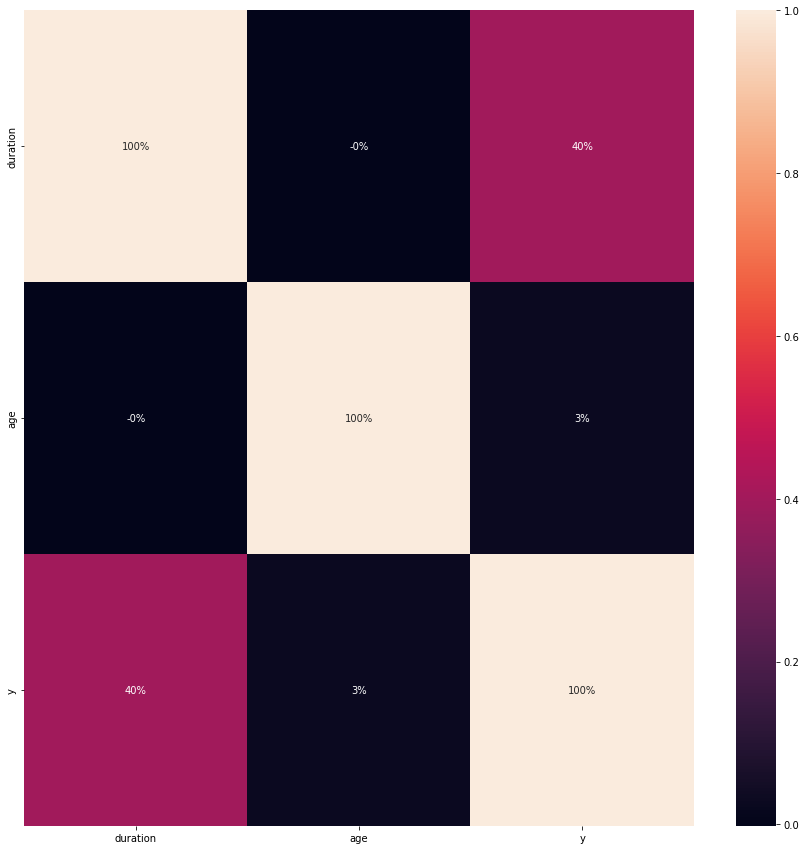

In [ ]:
plt.subplots(figsize=(15,15))
sns.heatmap(df6.corr(), annot = True, fmt = '0.0%')
plt.show

*A good correlation exists between duration and the target variable 'y'*

## **Model 1 (With RFE Selection Algorithm)** 

In [ ]:
y = clean_data['y']
x = clean_data.drop('y',axis=1)

Splitting the processed data into testing and training datasets

In [ ]:
os = SMOTE(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .75)

In [ ]:
columns = x_train.columns

In [ ]:
os_data_X,os_data_y=os.fit_resample(x_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

In [ ]:
clean_data_vars=clean_data.columns.values.tolist()
y=['y']
X=[i for i in clean_data if i not in y]

*Using RFE or Recursive Feature Elimination to eliminate the unimportant variables. RFE recursively iterates through the data and gives the best possible combination of columns to undergo logistic regression*

In [ ]:
logreg = LogisticRegression()
rfe = RFE(logreg)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False  True  True  True False False  True False False False
  True False False False False  True  True  True False  True  True  True
 False False False False False False  True  True False  True  True False
  True  True False  True  True  True  True  True False  True]
[23 18 19  1  1  1  3  5  1  2 20  6  1  4 13 12 17  1  1  1 21  1  1  1
  7 24 15 16 10 11  1  1  8  1  1 22  1  1  9  1  1  1  1  1 14  1]


In [ ]:
x.columns

Index(['age', 'duration', 'campaign', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

*Selecting the columns that have been selected by RFE and utilising then for creation of the model*

In [ ]:
cols=['duration','job_blue-collar','job_entrepreneur', 'job_housemaid', 'job_self-employed','job_unemployed','education_basic.6y', 
      'education_basic.9y', 'education_high.school','education_professional.course','education_university.degree', 'education_unknown',
      'contact_telephone', 'month_aug','month_jul','month_jun','month_may','month_nov', 'month_sep', 'day_of_week_mon', 'day_of_week_thu', 
      'day_of_week_tue','day_of_week_wed','poutcome_nonexistent','poutcome_success'] 
      
X=os_data_X[cols]
y=os_data_y['y']

In [ ]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.277187
         Iterations 8
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.600     
Dependent Variable:      y                    AIC:                  24368.1314
Date:                    2022-10-23 12:14     BIC:                  24585.3537
No. Observations:        43866                Log-Likelihood:       -12159.   
Df Model:                24                   LL-Null:              -30406.   
Df Residuals:            43841                LLR p-value:          0.0000    
Converged:               1.0000               Scale:                1.0000    
No. Iterations:          8.0000                                               
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(X_test)
y_pred

array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
print((logreg.score(X_test, y_test)*100))

91.1005744506246


*An accuracy is 91.1 % is reached*

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      5545
           1       0.91      0.91      0.91      5422

    accuracy                           0.91     10967
   macro avg       0.91      0.91      0.91     10967
weighted avg       0.91      0.91      0.91     10967



In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cnf_matrix

array([[5066,  479],
       [ 497, 4925]])

## **Model 2 (With All Columns)**

In [ ]:
y = clean_data['y']
x = clean_data.drop('y',axis=1)

*Splitting the processed data into testing and training datasets*

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .80)

In [ ]:
lreg = LogisticRegression()

*Fitting the Logistic Regression model*

In [ ]:
lreg.fit(x_train,y_train)

LogisticRegression()

In [ ]:
pred2 = lreg.predict(x_test)
pred2

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(y_test,pred2)*100

90.59180576631259

*An accuracy of 90.59 is reached, which is slightly less that the accuracy reached by using RFE*

In [ ]:
zero_count = np.count_nonzero(pred2 == 0)
zero_count

6175

In [ ]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5835
           1       0.66      0.36      0.47       755

    accuracy                           0.91      6590
   macro avg       0.79      0.67      0.71      6590
weighted avg       0.89      0.91      0.89      6590



In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test,pred2)
cnf_matrix

array([[5695,  140],
       [ 480,  275]])

*Overall, both the models have predicted with a high degree of accuracy, that there is a good chance that 'no' will be selected or that the customers won't be willing to choose the term deposit*

# **SVM**

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf')
svm.fit(x_train, y_train)

SVC()

In [ ]:
y_predsv = svm.predict(x_test)
y_predsv

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(y_test,y_predsv)*100

88.7556904400607

# **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [ ]:
y_predknn = knn.predict(x_test)
y_predknn

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(y_test,y_predknn)*100

89.39301972685888

# **BOOSTING**

## **XG Boost**

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clf = XGBClassifier(n_estimators=1000,random_state=100)
clf.fit(x_train, y_train)
predicted=clf.predict(x_test)

In [ ]:
y_predxgb = clf.predict(x_test)
y_predxgb

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(y_test,y_predxgb)*100

90.47040971168437

## **Gradient Boost**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc=GradientBoostingClassifier(n_estimators=1000,learning_rate=0.05,random_state=100,max_features=5 )
gbc.fit(x_train,y_train)

GradientBoostingClassifier(learning_rate=0.05, max_features=5,
                           n_estimators=1000, random_state=100)

In [ ]:
y_predgbc = gbc.predict(x_test)
y_predgbc

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(y_test,y_predgbc)*100

90.7587253414264

## **Ada Boost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
abr=AdaBoostClassifier(n_estimators=1000,learning_rate=0.05,random_state=100)
abr.fit(x_train,y_train)

AdaBoostClassifier(learning_rate=0.05, n_estimators=1000, random_state=100)

In [ ]:
y_predabc = abr.predict(x_test)
y_predabc

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(y_test,y_predabc)*100

90.60698027314112

# **BAGGING**

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
clf = BaggingClassifier(n_estimators = 1000, random_state = 22)

In [ ]:
clf.fit(x_train, y_train)

BaggingClassifier(n_estimators=1000, random_state=22)

In [ ]:
y_predbag = clf.predict(x_test)
y_predbag

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(y_test,y_predbag)*100

90.50075872534143

# **RANDOM FOREST CLASSIFIER**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
regressor = RandomForestClassifier(n_estimators = 10, random_state = 100)

In [ ]:
regressor.fit(x_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=100)

In [ ]:
predicted = regressor.predict(x_test)

In [ ]:
accuracy_score(y_test,predicted)*100

89.75720789074356

# **DECISION TREE CLASSIFIER**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier_model = DecisionTreeClassifier(min_samples_leaf=5) 
classifier_model.fit(x_train,y_train)

DecisionTreeClassifier(min_samples_leaf=5)

In [ ]:
predicted = classifier_model.predict(x_test)

In [ ]:
accuracy_score(y_test,predicted)*100

88.81638846737481

# **NEURAL NETWORKS MODEL**

In [ ]:
#cols=['duration','job_blue-collar','job_entrepreneur', 'job_housemaid', 'job_self-employed','job_unemployed','education_basic.6y', 
#     'education_basic.9y', 'education_high.school','education_professional.course','education_university.degree', 'education_unknown',
#      'contact_telephone', 'month_aug','month_jul','month_jun','month_may','month_nov', 'month_sep', 'day_of_week_mon', 'day_of_week_thu', 
#      'day_of_week_tue','day_of_week_wed','poutcome_nonexistent','poutcome_success'] 
      
x=clean_data.drop('y',axis=1)
y=clean_data['y']
x.head

<bound method NDFrame.head of        age  duration  campaign  job_blue-collar  job_entrepreneur  \
0       49      3.78         4                1                 0   
1       37      3.37         2                0                 1   
2       78     19.13         1                0                 0   
3       36      2.00         2                0                 0   
4       59      6.13         2                0                 0   
...    ...       ...       ...              ...               ...   
32945   28      3.20         1                0                 0   
32946   52      1.07         1                0                 0   
32947   54      2.18         4                0                 0   
32948   29      2.75         1                0                 0   
32949   35      9.07         3                0                 0   

       job_housemaid  job_management  job_retired  job_self-employed  \
0                  0               0            0                  0 

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.20, random_state=0)
y_test

5379     0
13301    0
15089    0
8998     0
18820    0
        ..
22982    0
29248    0
28842    0
12856    0
27885    0
Name: y, Length: 6590, dtype: int64

In [ ]:
tf.random.set_seed(42)

# STEP1: Creating the model

model= tf.keras.Sequential([
                            tf.keras.layers.Dense(24, activation='relu'),
                            tf.keras.layers.Dense(20, activation='relu'),
                            tf.keras.layers.Dense(16, activation='relu'),
                            tf.keras.layers.Dense(12, activation='relu'),
                            tf.keras.layers.Dense(8, activation='relu'),
                            tf.keras.layers.Dense(4, activation='relu'),
                            tf.keras.layers.Dense(2, activation='relu'),
                            tf.keras.layers.Dense(1, activation='sigmoid')
])

# STEP2: Compiling the model

model.compile(loss= tf.keras.losses.binary_crossentropy,
              optimizer= tf.keras.optimizers.Adam(lr=0.01),
              metrics= [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        
              ]
              )

# STEP 3: Fitting the model

history= model.fit(x_train, y_train, epochs= 100)

Epoch 1/100
824/824 [==============================] - 3s 2ms/step - loss: 0.3842 - accuracy: 0.8878 - precision: 0.0000e+00
Epoch 2/100
824/824 [==============================] - 2s 2ms/step - loss: 0.3512 - accuracy: 0.8878 - precision: 0.0000e+00
Epoch 3/100
824/824 [==============================] - 2s 2ms/step - loss: 0.3511 - accuracy: 0.8878 - precision: 0.0000e+00
Epoch 4/100
824/824 [==============================] - 2s 2ms/step - loss: 0.3512 - accuracy: 0.8878 - precision: 0.0000e+00
Epoch 5/100
824/824 [==============================] - 2s 2ms/step - loss: 0.3512 - accuracy: 0.8878 - precision: 0.0000e+00
Epoch 6/100
824/824 [==============================] - 2s 2ms/step - loss: 0.3512 - accuracy: 0.8878 - precision: 0.0000e+00
Epoch 7/100
824/824 [==============================] - 2s 2ms/step - loss: 0.3512 - accuracy: 0.8878 - precision: 0.0000e+00
Epoch 8/100
824/824 [==============================] - 2s 2ms/step - loss: 0.3512 - accuracy: 0.8878 - precision: 0.0000e+00


In [ ]:
model.evaluate(x_test,y_test)

206/206 [==============================] - 1s 1ms/step - loss: 0.3560 - accuracy: 0.8854 - precision: 0.0000e+00


[0.35602468252182007, 0.8854324817657471, 0.0]

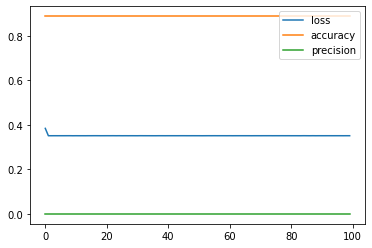

In [ ]:
pd.DataFrame(history.history).plot()